In [1]:
import subprocess
import os
import pandas as pd

folder = 'extraido'

csvs = [f for f in os.listdir(folder) if f.endswith('.csv')]
csvs

df = pd.DataFrame()
for csv in csvs:
  new_df = pd.read_csv(f'extraido/{csv}', sep=';')
  df = pd.concat([df, new_df])

df['data'] = pd.to_datetime(df['data'])
df.sort_values(by='data')


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
2212,Nordeste,AL,NaN,27,NaN,NaN,NaN,2020-02-25,9,3337357.0,0.0,0,0,0,NaN,NaN,NaN
158,Norte,RO,NaN,11,NaN,NaN,NaN,2020-02-25,9,1777225.0,0.0,0,0,0,NaN,NaN,NaN
3002,Sudeste,RJ,NaN,33,NaN,NaN,NaN,2020-02-25,9,17264943.0,0.0,0,0,0,NaN,NaN,NaN
2844,Sudeste,ES,NaN,32,NaN,NaN,NaN,2020-02-25,9,4018650.0,0.0,0,0,0,NaN,NaN,NaN
2686,Sudeste,MG,NaN,31,NaN,NaN,NaN,2020-02-25,9,21168791.0,0.0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105244,Nordeste,CE,Santa Quitéria,23,231220.0,23011.0,11ª REGIAO SOBRAL,2024-10-05,40,43703.0,10508.0,0,77,0,NaN,NaN,0.0
498094,Sul,RS,Veranópolis,43,432280.0,43025.0,REGIAO 25,2024-10-05,40,26241.0,9194.0,0,82,0,NaN,NaN,0.0
254527,Sudeste,MG,Ibitiúra de Minas,31,312990.0,31006.0,POCOS DE CALDAS,2024-10-05,40,3488.0,1330.0,1,7,0,NaN,NaN,0.0
254430,Sudeste,MG,Ibirité,31,312980.0,31018.0,CONTAGEM,2024-10-05,40,180204.0,16882.0,2,460,0,NaN,NaN,1.0


In [2]:
df.dtypes

regiao                            object
estado                            object
municipio                         object
coduf                              int64
codmun                           float64
codRegiaoSaude                   float64
nomeRegiaoSaude                   object
data                      datetime64[ns]
semanaEpi                          int64
populacaoTCU2019                 float64
casosAcumulado                   float64
casosNovos                         int64
obitosAcumulado                    int64
obitosNovos                        int64
Recuperadosnovos                 float64
emAcompanhamentoNovos            float64
interior/metropolitana           float64
dtype: object

In [3]:
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd

def smooth_covid(Tx, x, w):
    # Convert datetime to numeric (timestamps)
    Tx_numeric = pd.to_datetime(Tx).astype(np.int64) // 10**9  # Convert to seconds since epoch

    # Identify indices where data is non-zero or non-null
    iz = np.where(np.diff(x) != 0)[0] + 1
    iz_first, iz_last = iz[0], iz[-1]
    
    Tz = Tx_numeric[iz]
    z = x[iz]

    # Interpolate with NaN handling
    interpolator = interp1d(Tz, z, kind='linear', fill_value="extrapolate")
    y_interp_NaN = interpolator(Tx_numeric)  # Apply interpolation on numeric datetime
    y_interp = np.copy(x)
    y_interp[iz_first:iz_last] = y_interp_NaN[iz_first:iz_last]

    # Smooth the interpolated data
    y_smoothed = pd.Series(y_interp).rolling(window=w, center=True).mean().to_numpy()
    
    return y_smoothed, y_interp, Tx, z

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter

def save_figs(df1, df2, population_col, cases_col, date_col, df1_legend, df2_legend):
  # Me = pd.read_csv('MG.csv', sep=';').sort_values(by='date')
  population_df1 = df1[population_col].max()
  cases_df1 = (df1[cases_col] / population_df1 * 1e5).values
  dates_df1 = pd.to_datetime(df1[date_col].values)
  smoothed_df1, *_ = smooth_covid(dates_df1, cases_df1, 7)
  df_plot1 = pd.DataFrame({"values": smoothed_df1, "dates": dates_df1}).sort_values(by="dates")
  

  # Mc = pd.read_excel('PARACATU.xlsx').sort_values(by='date')
  population_df2 = df2[population_col].max()
  cases_df2 = (df2[cases_col] / population_df2 * 1e5).values
  y = np.concatenate([np.zeros(len(cases_df1) - len(cases_df2)), cases_df2])  # Align lengths by padding with zeros
  smoothed_df2, *_ = smooth_covid(dates_df1, y, 7)
  df_plot2 = pd.DataFrame({"values": smoothed_df2, "dates": dates_df1}).sort_values(by="dates")

  # Calculate differences and signed square differences
  d_nnC = smoothed_df2 - smoothed_df1
  df_plot3 = pd.DataFrame({"values": d_nnC, "dates": dates_df1}).sort_values(by="dates")
  ssd_nnC = np.sign(d_nnC) * (d_nnC ** 2) / 1e5
  df_plot4 = pd.DataFrame({"values": ssd_nnC, "dates": dates_df1}).sort_values(by="dates")

  # Generate dynamic date ticks and labels
  # DATE_ticks = pd.date_range(start="2020-04-01", periods=13, freq="MS")
  # DATE_ticklabels = DATE_ticks.strftime('%b/%y')

  # Create plots
  fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
  plt.rcParams.update({'axes.titlesize': 10, 'axes.labelsize': 9, 'axes.labelpad': 10})

  # Plot configurations
  plot_params = [
      (df_plot1, df_plot2, "Surveillance", [-600, 6000], [0, 6000], ['$0$', '$6\\times10^3$']),
      (df_plot3, None, "Difference", [-100, 1000], [0, 1000], ['$0$', '$10^3$']),
      (df_plot4 , None, "SSD", [-1, 10], [0, 10], ['$0$', '$10^5$'])
  ]

  for ax, (data1, data2, ylabel, ylim, yticks, yticklabels) in zip(axs, plot_params):
      ax.plot(data1["dates"], data1["values"], 'r', linewidth=2)
      if data2 is not None:
          ax.plot(data1["dates"], data2["values"], 'k', linewidth=2)
          ax.legend([df1_legend, df2_legend], loc='upper left', frameon=False)
      ax.axhline(0, linestyle='--', color=[0.6, 0.6, 0.6])
      # ax.set_ylim(ylim)
      # ax.set_yticks(yticks)
      # ax.set_yticklabels(yticklabels)
      # ax.set_ylabel(ylabel, rotation=90)

  # Set x-axis tick labels on the last subplot
  # axs[-1].set_xticks(DATE_ticks)
  # axs[-1].set_xticklabels(DATE_ticklabels, rotation=45)

  plt.tight_layout()
  plt.show()

  # Uncomment to save as a PDF
  fig.savefig('figuras.pdf', format='pdf', bbox_inches='tight')
  return df_plot1, df_plot2

# Figura igual do paper com os dados do brasil.io

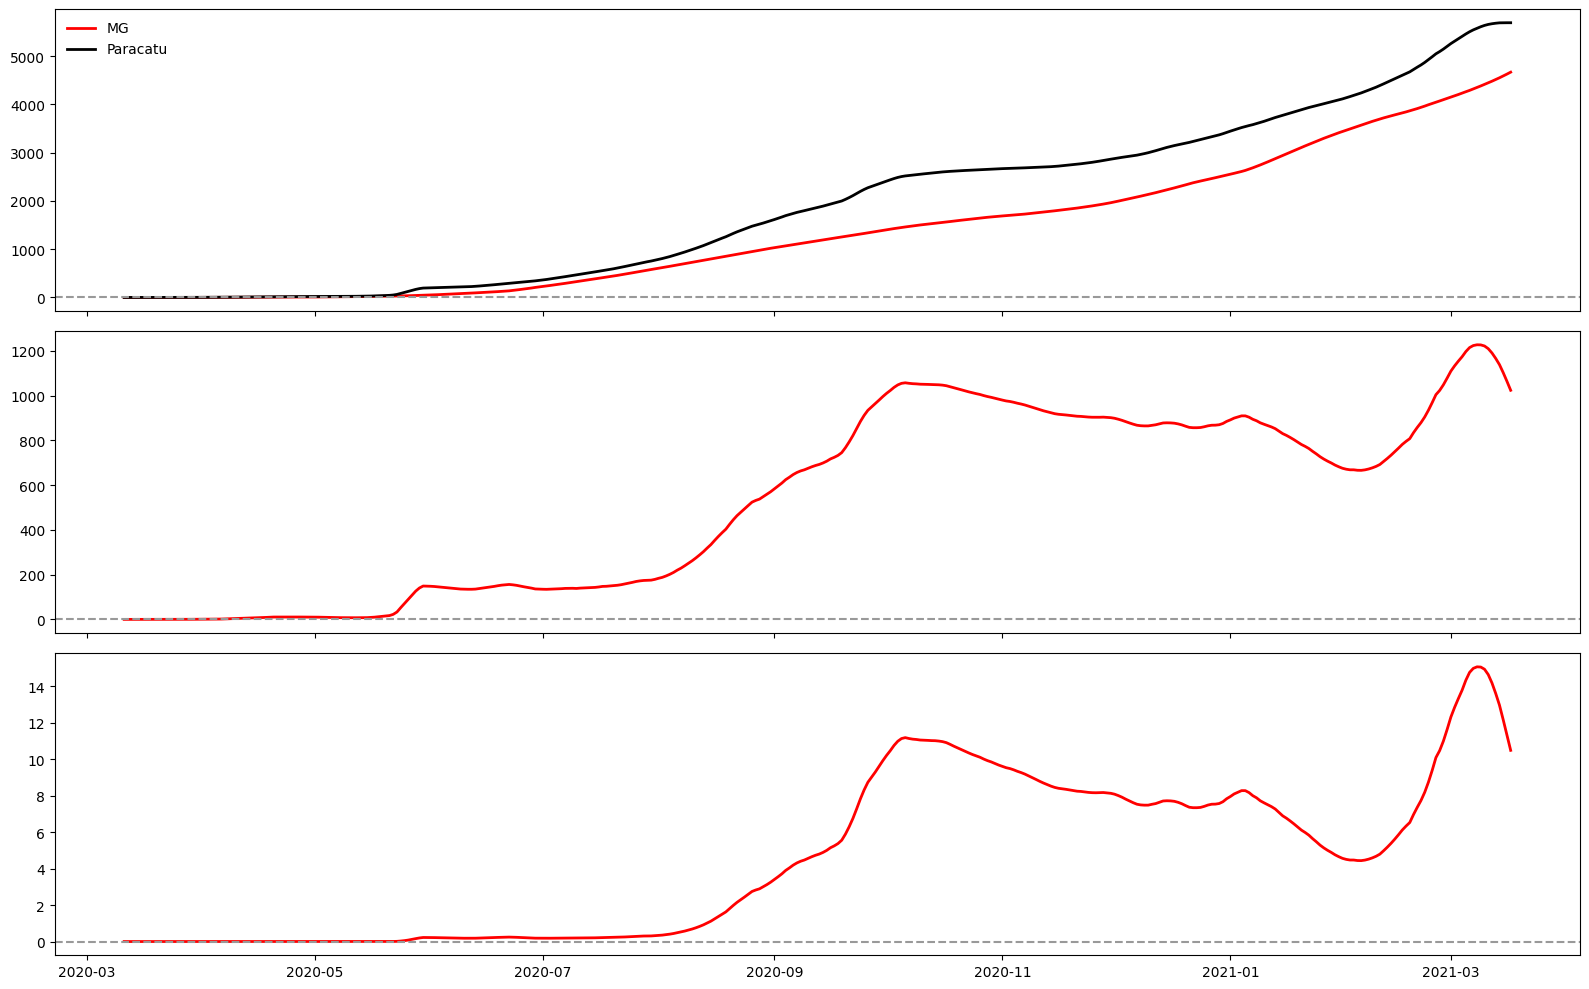

In [5]:
brasilio_df1 = pd.read_csv('analises/MG.csv', sep=';').sort_values(by='date')
brasilio_df2 = pd.read_excel('analises/PARACATU.xlsx').sort_values(by='date')

_, _ = save_figs(brasilio_df1, brasilio_df2, 'estimated_population', 'last_available_confirmed', 'date', 'MG', 'Paracatu')

# Figura com dados do datasus

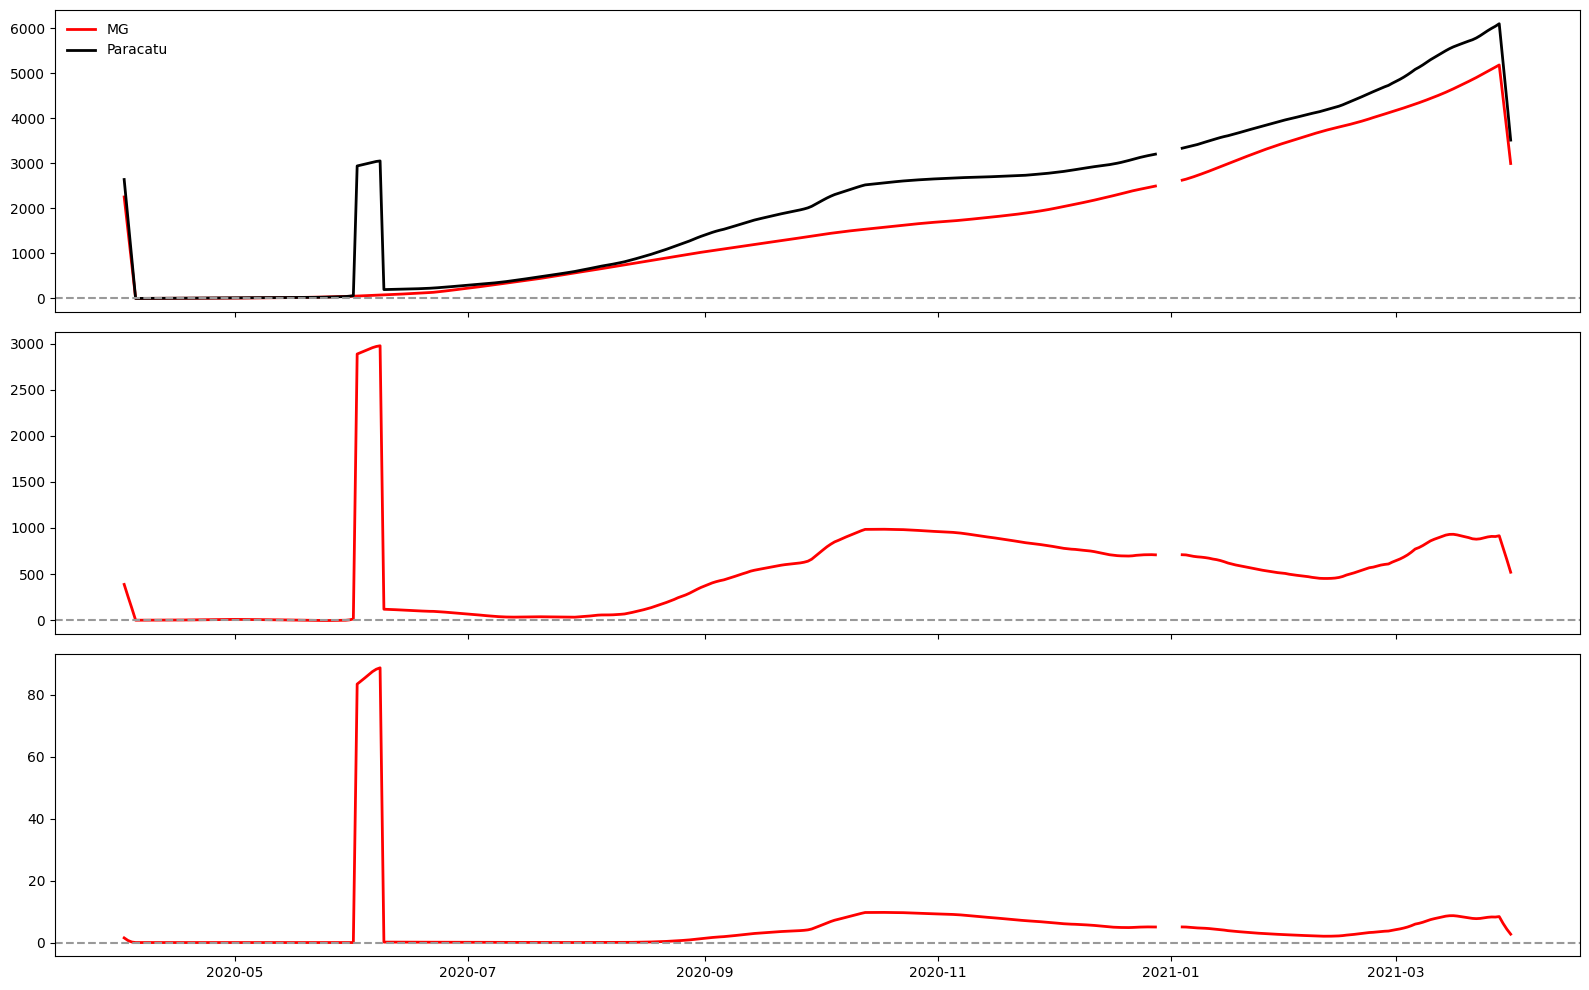

In [6]:
min_filter = '2020-04-01'
max_filter = '2021-04-01'

datasus_df1 = df[(df['estado'] == 'MG') & (df['municipio'].isna()) & (df['populacaoTCU2019'].notna()) & (df['data'] > min_filter) & (df['data'] < max_filter)]
datasus_df2 = df[(df['municipio'] == 'Paracatu') & (df['populacaoTCU2019'].notna()) & (df['data'] > min_filter) & (df['data'] < max_filter)]

_, _ = save_figs(datasus_df1, datasus_df2, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')

# Removendo outliner utilizando o desvio padrão

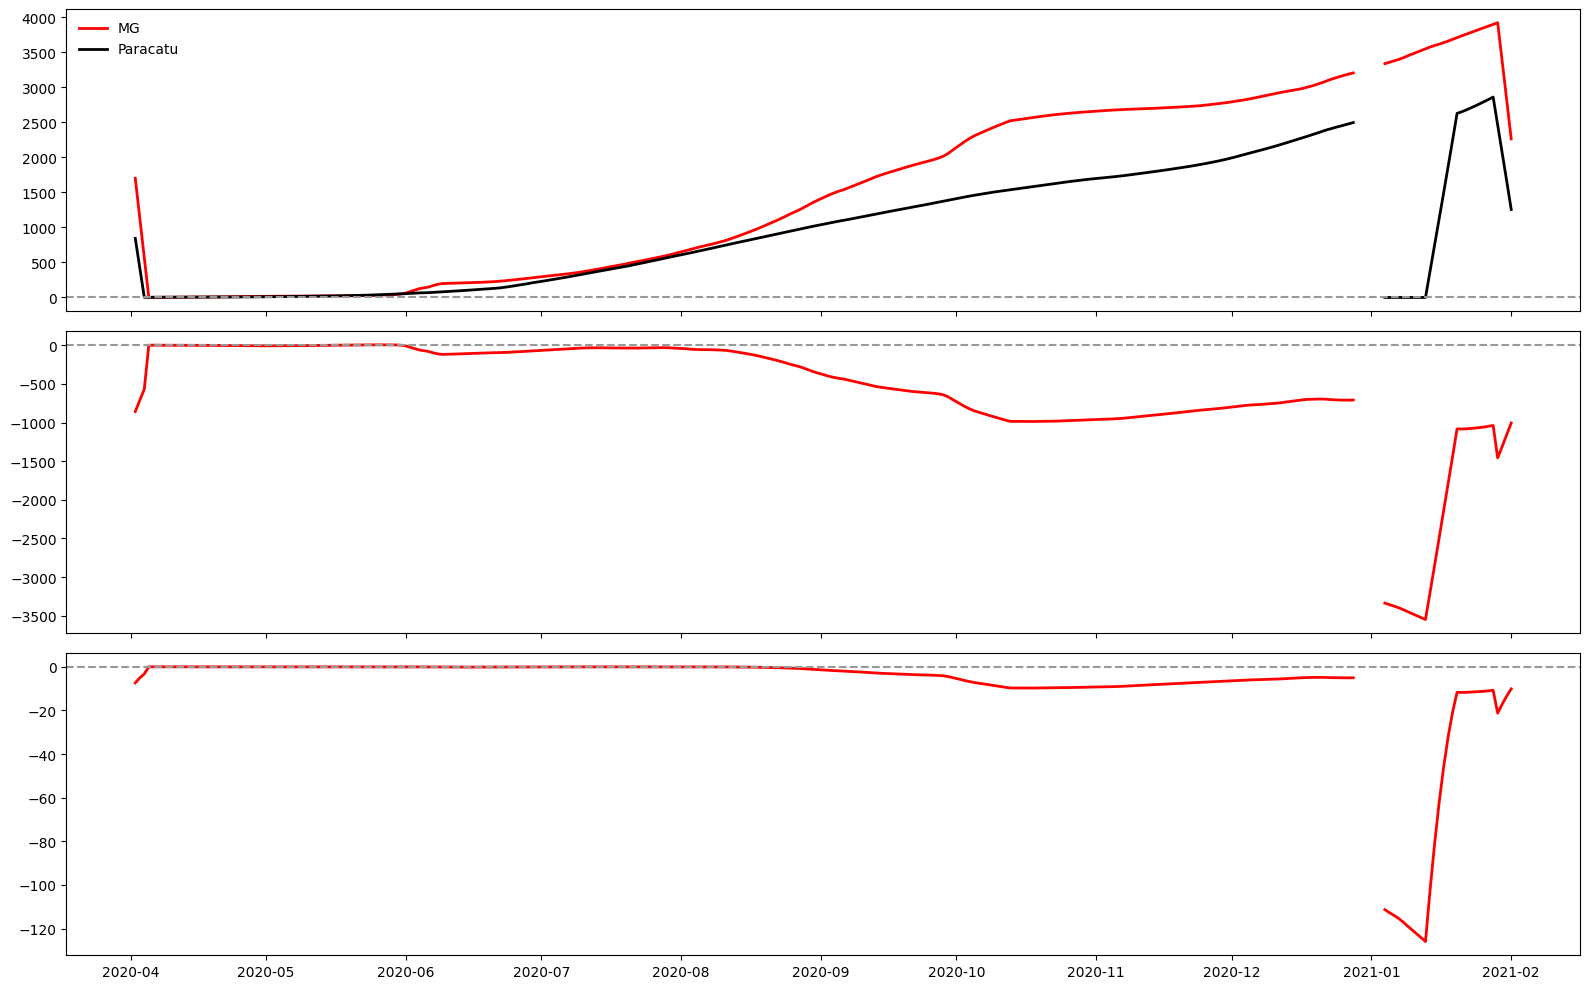

In [7]:
min_filter = '2020-04-01'
max_filter = '2021-04-01'

datasus_df1 = df[(df['estado'] == 'MG') & (df['municipio'].isna()) & (df['populacaoTCU2019'].notna()) & (df['data'] > min_filter) & (df['data'] < max_filter)]
datasus_df2 = df[(df['municipio'] == 'Paracatu') & (df['populacaoTCU2019'].notna()) & (df['data'] > min_filter) & (df['data'] < max_filter)]

# remover outlier
normalized_datasus_df1 = datasus_df1[datasus_df1['casosAcumulado'] <= (2 * datasus_df1['casosAcumulado'].std())]
normalized_datasus_df2 = datasus_df2[datasus_df2['casosAcumulado'] <= (2 * datasus_df2['casosAcumulado'].std())]

_, _ = save_figs(normalized_datasus_df2, normalized_datasus_df1, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')

# Testes (o gráfico está cortado)

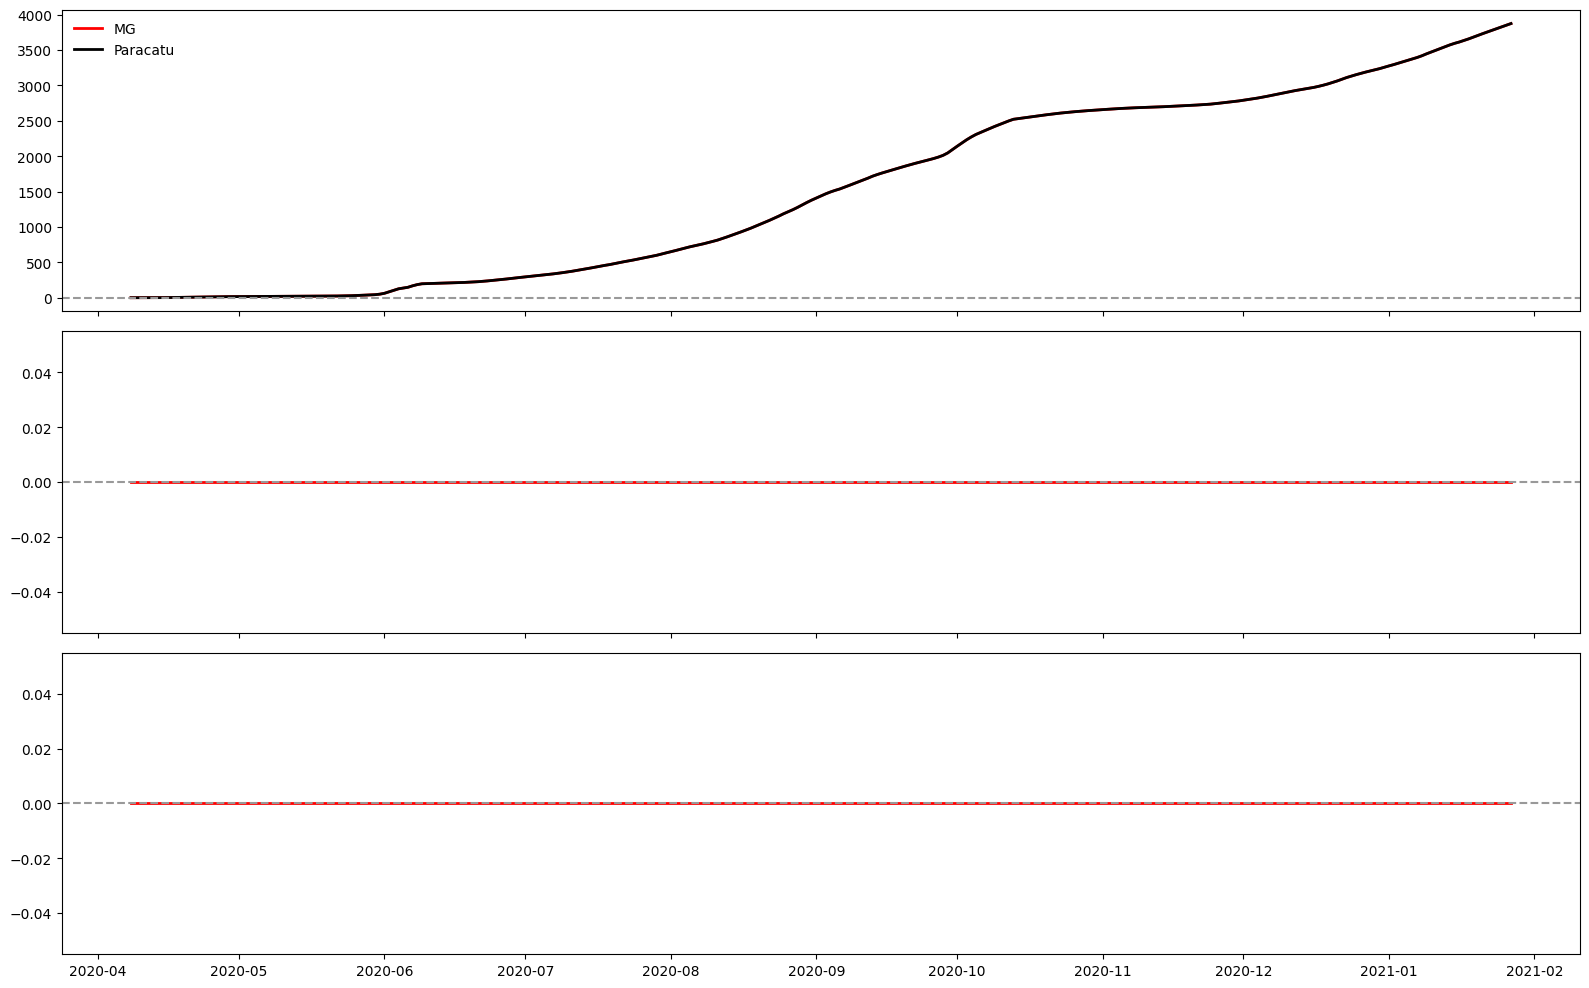

In [8]:
# brasilio_df2[(['last_available_confirmed', 'date'])].sort_values(by='date').tail(),datasus_df2[(datasus_df2['data'] <= '2021-03-29')][['casosAcumulado', 'data']].sort_values(by='data').tail()

algumacoisa = brasilio_df2[['last_available_confirmed', 'date']].merge(datasus_df2[['casosAcumulado', 'data', 'populacaoTCU2019']], left_on='date', right_on='data')
algumacoisa['casosAcumulado'] = algumacoisa['casosAcumulado'].astype(int)
algumacoisa['diferenca'] = algumacoisa['casosAcumulado'] - algumacoisa['last_available_confirmed']
algumacoisa.describe()
algumacoisa1 = algumacoisa[algumacoisa['casosAcumulado'] <= (2 * algumacoisa['casosAcumulado'].std())]
algumacoisa1.dtypes

_, _ = save_figs(algumacoisa1, algumacoisa1, 'populacaoTCU2019', 'casosAcumulado', 'data', 'MG', 'Paracatu')